In [1]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import gymnasium
import cookiedisaster

from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import torch.nn.functional as F
from torch.utils.data import DataLoader

from AgentQ import AgentQ

## Define a training loop training a model

In [2]:
# Instantiate the cookie disaster environments
envs = [gymnasium.make("cookiedisaster-v1"), gymnasium.make("cookiedisaster-v2"), gymnasium.make("cookiedisaster-v3")]

def train(episodes, hyperparameters, horizon=1500, horizon_std=500, horizon_min=100):
    # Initialize the agent
    agent = AgentQ(**hyperparameters)

    # Randomly sample environment and number of timesteps
    for episode in range(1, episodes):
        if not episode % 100:
            print("Episode:", episode)
        env = np.random.choice(envs)
        timesteps = torch.max(torch.round(dist.Normal(horizon, horizon_std).sample()), torch.tensor([horizon_min]))

        agent.learn(env=env, timesteps=timesteps)

    # Return the agent
    return agent

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


## Then we can train the model for a given number of episodes

In [271]:
# Perform hyperparameter tuning
episodes = 500
hyperparameters = [
    {"lr": 0.001, "gamma": 0.99},
    {"lr": 0.0005, "gamma": 0.99},
    {"lr": 0.0001, "gamma": 0.99},
    {"lr": 0.001, "gamma": 0.95},
    {"lr": 0.0005, "gamma": 0.95},
    {"lr": 0.0001, "gamma": 0.95},
]

agents = []
for settings in hyperparameters:
    agents.append(train(episodes, settings))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.

Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 100
Episode: 200
Episode: 300
Episode: 400


## And plot the cumulative reward whilst learning

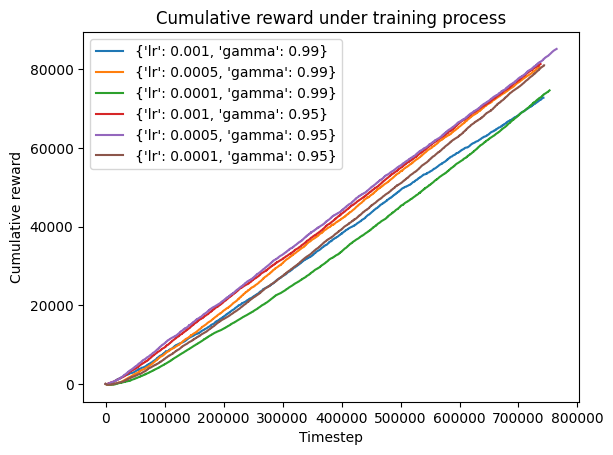

In [272]:
for i in range(len(agents)):
    plt.plot(np.arange(len(agents[i].cumulative_rewards)), agents[i].cumulative_rewards, label=str(hyperparameters[i]))
plt.title("Cumulative reward under training process")
plt.xlabel("Timestep")
plt.ylabel("Cumulative reward")
plt.legend()
plt.show()

## At last, lets measure the performance on each environment seperately

In [273]:
environment_cumulative_rewards = [[[0] for _ in range(len(envs))] for _ in range(len(agents))]

# Iterate each environment, running them for 10000 iterations, storing cumulative reward
for i in range(len(agents)):
    for j in range(len(envs)):
        env = envs[j]
        observation, info = env.reset()

        for timestep in range(10000):
            action = agents[i].select_action(observation)
            
            # Take the action and observe new state
            observation, reward, terminated, truncated, info = env.step(action)
            environment_cumulative_rewards[i][j].append(environment_cumulative_rewards[i][j][-1] + reward)

## And plot them

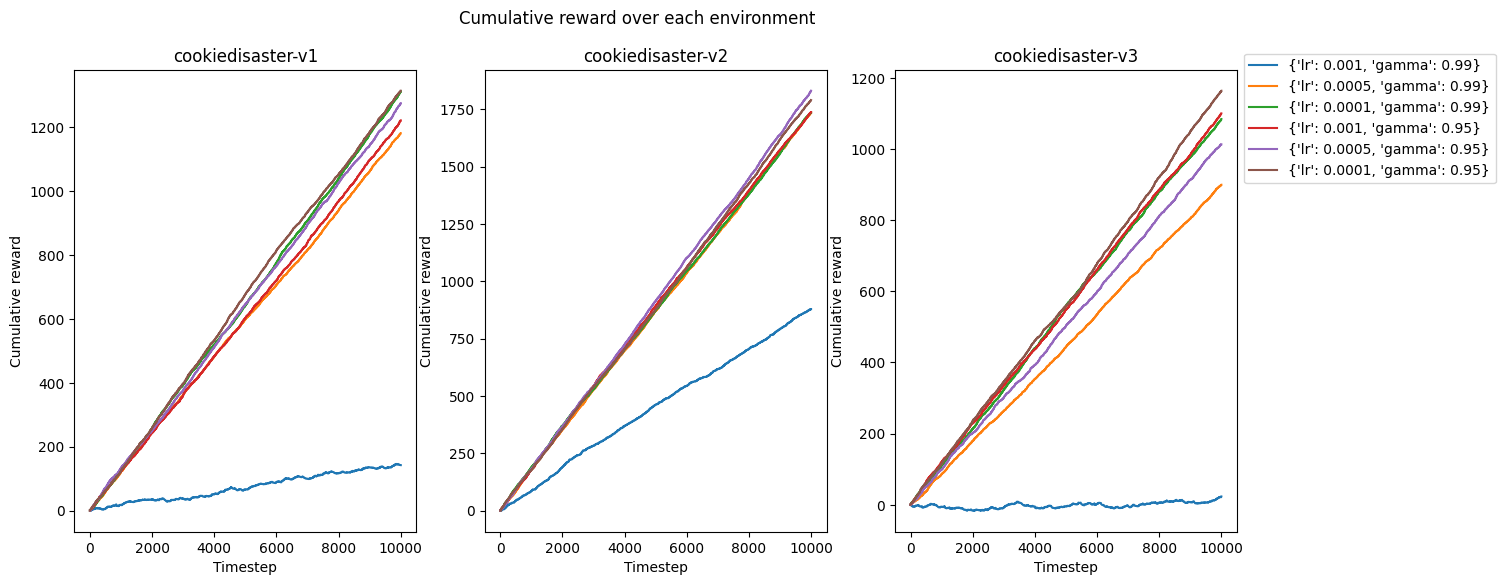

In [274]:
fig, axes = plt.subplots(ncols = len(envs), figsize=(15, 6))
for i in range(len(envs)):
    for j in range(len(agents)):
        axes[i].plot(np.arange(len(environment_cumulative_rewards[j][i])), environment_cumulative_rewards[j][i], label=str(hyperparameters[j]))
        axes[i].set_title("cookiedisaster-v" + str(i+1))
        axes[i].set_xlabel("Timestep")
        axes[i].set_ylabel("Cumulative reward")
plt.suptitle("Cumulative reward over each environment")
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.show()

## Finally, train the final model

In [3]:
agent = train(episodes=500, hyperparameters={"lr":0.0001, "gamma":0.95})

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.

Episode: 100
Episode: 200
Episode: 300
Episode: 400


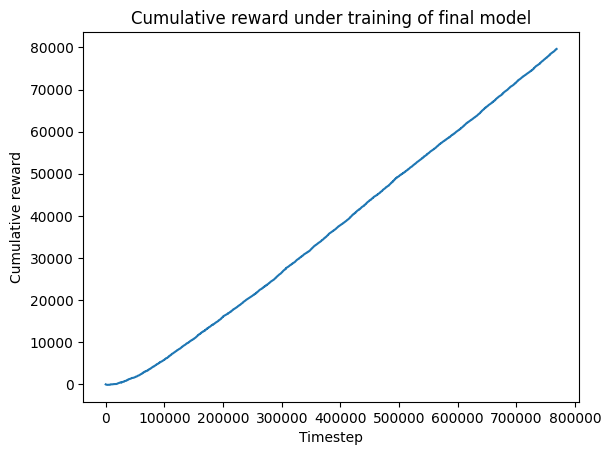

In [4]:
# And plot cumulative reward
plt.plot(np.arange(len(agent.cumulative_rewards)), agent.cumulative_rewards)
plt.title("Cumulative reward under training of final model")
plt.xlabel("Timestep")
plt.ylabel("Cumulative reward")
plt.show()

In [5]:
final_environment_cumulative_rewards = [[0] for _ in range(len(envs))]

# Iterate each environment, running them for 10000 iterations, storing cumulative reward
for i in range(len(envs)):
    env = envs[i]
    observation, info = env.reset()

    for timestep in range(10000):
        action = agent.select_action(observation)
        
        # Take the action and observe new state
        observation, reward, terminated, truncated, info = env.step(action)
        final_environment_cumulative_rewards[i].append(final_environment_cumulative_rewards[i][-1] + reward)

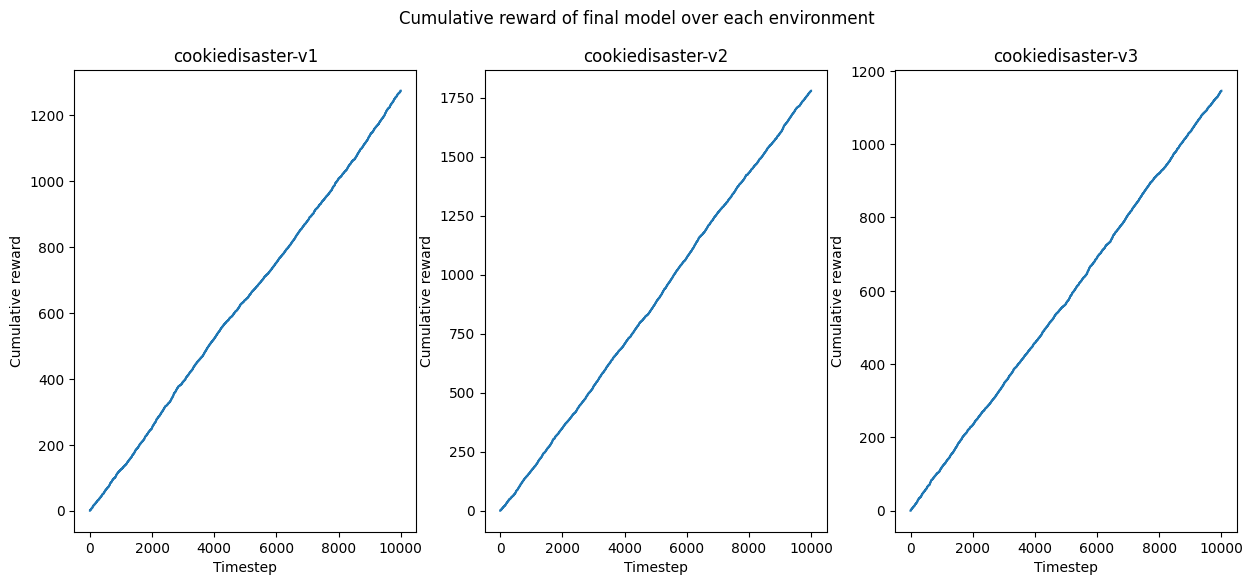

In [6]:
fig, axes = plt.subplots(ncols = len(envs), figsize=(15, 6))
for i in range(len(envs)):
    axes[i].plot(np.arange(len(final_environment_cumulative_rewards[i])), final_environment_cumulative_rewards[i])
    axes[i].set_title("cookiedisaster-v" + str(i+1))
    axes[i].set_xlabel("Timestep")
    axes[i].set_ylabel("Cumulative reward")
plt.suptitle("Cumulative reward of final model over each environment")
plt.show()

## And finally save it

In [7]:
agent.save("AgentQ.pt")

## Verify that loading a model also works

In [10]:
agent_loaded = AgentQ()
agent_loaded.load("AgentQ.pt")

loaded_environment_cumulative_rewards = [[0] for _ in range(len(envs))]

# Iterate each environment, running them for 10000 iterations, storing cumulative reward
for i in range(len(envs)):
    env = envs[i]
    observation, info = env.reset()

    for timestep in range(10000):
        action = agent_loaded.select_action(observation)
        
        # Take the action and observe new state
        observation, reward, terminated, truncated, info = env.step(action)
        loaded_environment_cumulative_rewards[i].append(loaded_environment_cumulative_rewards[i][-1] + reward)

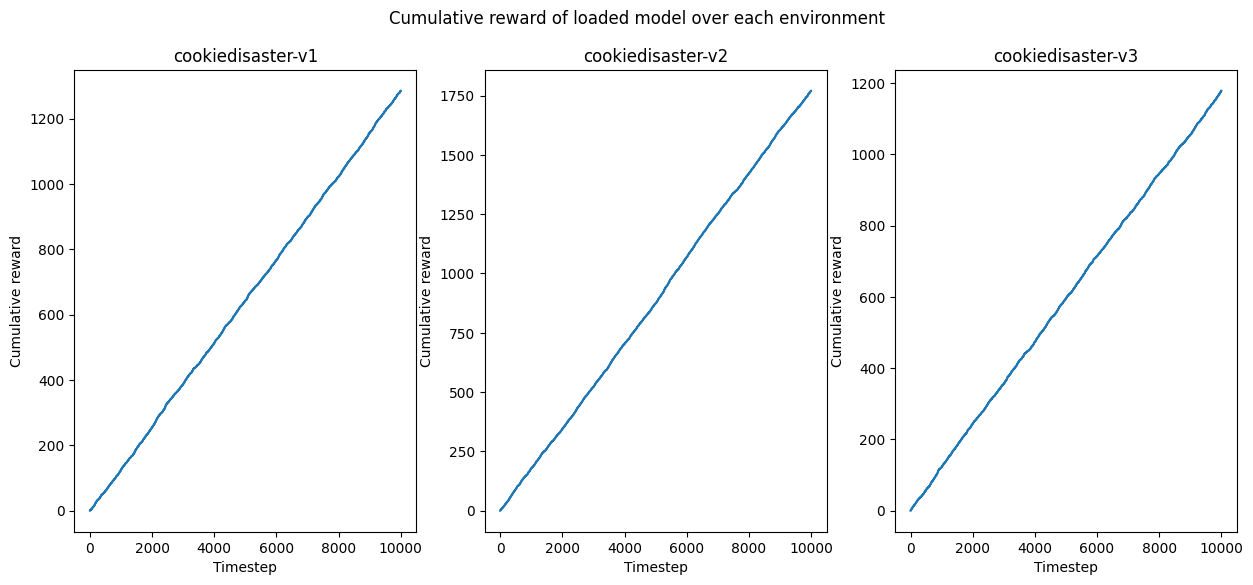

In [11]:
fig, axes = plt.subplots(ncols = len(envs), figsize=(15, 6))
for i in range(len(envs)):
    axes[i].plot(np.arange(len(loaded_environment_cumulative_rewards[i])), loaded_environment_cumulative_rewards[i])
    axes[i].set_title("cookiedisaster-v" + str(i+1))
    axes[i].set_xlabel("Timestep")
    axes[i].set_ylabel("Cumulative reward")
plt.suptitle("Cumulative reward of loaded model over each environment")
plt.show()

## We can also visualize the final model

In [13]:
env = gymnasium.make("cookiedisaster-v1", render_mode="human")
observation, info = env.reset()

for timestep in range(10000):
    action = agent_loaded.select_action(observation)
    observation, reward, terminated, truncated, info = env.step(action)

KeyboardInterrupt: 